In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# CSV 파일 로드
data_path = 'D:\galaxy_classification\data.csv'
image_dir = 'D:\galaxy_classification\images'

data = pd.read_csv(data_path)

# 클래스 매핑
class_mapping = {'S': 0, 'E': 1, 'SB': 2, 'EDGE': 3, 'STAR': 4}

# 데이터셋을 학습용과 검증용으로 분리
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# 데이터 제너레이터 생성 함수
def image_generator(data, batch_size, image_dir, class_mapping, augment=False):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    ) if augment else ImageDataGenerator()

    num_samples = data.shape[0]
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = data.iloc[offset:offset+batch_size]
            
            images = []
            labels = []
            for _, row in batch_samples.iterrows():
                image_id = row['image_id']
                label = row['class']
                
                # 이미지 파일 경로
                image_path = os.path.join(image_dir, f"{image_id}.jpg")
                
                # 이미지 로드 및 전처리
                if os.path.exists(image_path):
                    img = load_img(image_path, target_size=(128, 128))
                    img = img_to_array(img) / 255.0
                    images.append(img)
                    labels.append(class_mapping[label])
            
            X = np.array(images)
            y = to_categorical(np.array(labels), num_classes=len(class_mapping))
            
            if augment:
                yield next(datagen.flow(X, y, batch_size=batch_size))
            else:
                yield X, y

# 배치 사이즈 설정
batch_size = 64

train_generator = image_generator(train_data, batch_size, image_dir, class_mapping, augment=True)
val_generator = image_generator(val_data, batch_size, image_dir, class_mapping, augment=False)



In [2]:
# VGG16 모델 불러오기 (사전 학습된 가중치 사용, 마지막 층 제거)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# 새로운 최상위 층 추가
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_mapping), activation='softmax')
])

# 사전 학습된 층은 학습되지 않도록 설정
base_model.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 14,780,997
Trainable params: 66,309
Non-trainable params: 14,714,688
_________________________________________________________________


In [3]:
# 모델 훈련
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=6,
    validation_data=val_generator,
    validation_steps=len(val_data) // batch_size,
    verbose=1
)

Epoch 1/6
2994/2994 [==============================] - 1648s 548ms/step - loss: 1.0903 - accuracy: 0.5109 - val_loss: 0.9898 - val_accuracy: 0.5540
Epoch 2/6
2994/2994 [==============================] - 1860s 620ms/step - loss: 1.0127 - accuracy: 0.5496 - val_loss: 0.9627 - val_accuracy: 0.5691
Epoch 3/6
2994/2994 [==============================] - 1858s 621ms/step - loss: 0.9984 - accuracy: 0.5557 - val_loss: 0.9586 - val_accuracy: 0.5657
Epoch 4/6
2994/2994 [==============================] - 1856s 620ms/step - loss: 0.9905 - accuracy: 0.5608 - val_loss: 0.9298 - val_accuracy: 0.5866
Epoch 5/6
2994/2994 [==============================] - 1855s 620ms/step - loss: 0.9847 - accuracy: 0.5631 - val_loss: 0.9248 - val_accuracy: 0.5883
Epoch 6/6
2994/2994 [==============================] - 1858s 621ms/step - loss: 0.9832 - accuracy: 0.5631 - val_loss: 0.9178 - val_accuracy: 0.5919


In [4]:
# 모델 저장
model.save('D:\galaxy_classification\galaxy_classifier_ver4.h5')

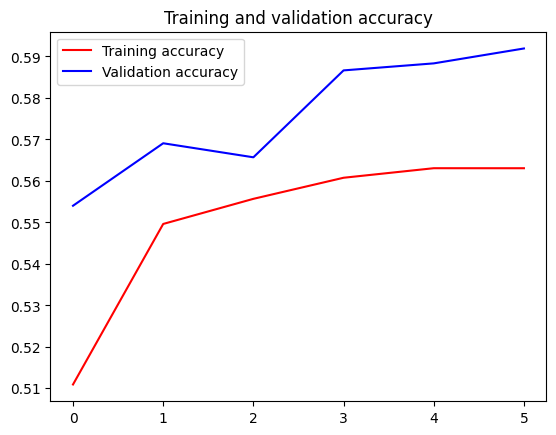

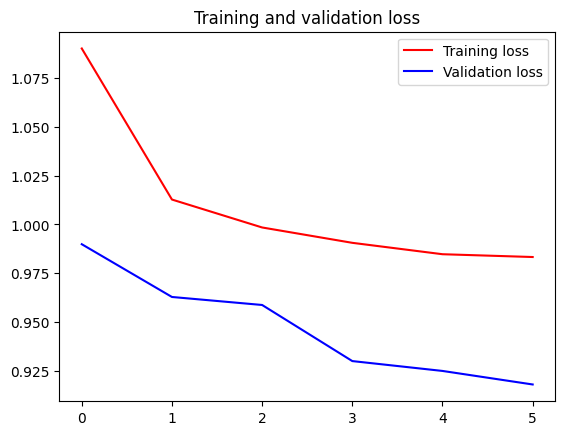

In [5]:
# 훈련 및 검증 정확도와 손실 그래프 그리기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
